## Wrapper Methods

In this project, you'll analyze data from a survey conducted by Fabio Mendoza Palechor and Alexis de la Hoz Manotas that asked people about their eating habits and weight. The data was obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+). Categorical variables were changed to numerical ones in order to facilitate analysis.

First, you'll fit a logistic regression model to try to predict whether survey respondents are obese based on their answers to questions in the survey. After that, you'll use three different wrapper methods to choose a smaller feature subset.

You'll use sequential forward selection, sequential backward floating selection, and recursive feature elimination. After implementing each wrapper method, you'll evaluate the model accuracy on the resulting smaller feature subsets and compare that with the model accuracy using all available features.

In [36]:
# Import libraries
import pandas as pd

## Evaluating a Logistic Regression Model

The data set `obesity` contains 18 predictor variables. Here's a brief description of them.

* `Gender` is `1` if a respondent is male and `0` if a respondent is female.
* `Age` is a respondent's age in years.
* `family_history_with_overweight` is `1` if a respondent has family member who is or was overweight, `0` if not.
* `FAVC` is `1` if a respondent eats high caloric food frequently, `0` if not.
* `FCVC` is `1` if a respondent usually eats vegetables in their meals, `0` if not.
* `NCP` represents how many main meals a respondent has daily (`0` for 1-2 meals, `1` for 3 meals, and `2` for more than 3 meals).
* `CAEC` represents how much food a respondent eats between meals on a scale of `0` to `3`.
* `SMOKE` is `1` if a respondent smokes, `0` if not.
* `CH2O` represents how much water a respondent drinks on a scale of `0` to `2`.
* `SCC` is `1` if a respondent monitors their caloric intake, `0` if not.
* `FAF` represents how much physical activity a respondent does on a scale of `0` to `3`.
* `TUE` represents how much time a respondent spends looking at devices with screens on a scale of `0` to `2`.
* `CALC` represents how often a respondent drinks alcohol on a scale of `0` to `3`.
* `Automobile`, `Bike`, `Motorbike`, `Public_Transportation`, and `Walking` indicate a respondent's primary mode of transportation. Their primary mode of transportation is indicated by a `1` and the other columns will contain a `0`.

The outcome variable, `NObeyesdad`, is a `1` if a patient is obese and a `0` if not.

Use the `.head()` method and inspect the data.

In [37]:
# https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+

# Load the data
df = pd.read_csv("obesity.csv")

# Inspect the data
print(df.head(5))
print(df.info())

   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        

### Split the data into `X` and `y`

In order to use a linear regression model, you'll need to split the data into two parts: the predictor variables and an outcome variable. Do this by splitting the data into a DataFrame of predictor variables called `X` and a Series of outcome variables `y`.

In [38]:
X = df.drop(["NObeyesdad"], axis=1)
y = df.NObeyesdad

In [39]:
X["Gender"]=X["Gender"].apply(lambda gender: 0 if gender=="Female" else 1)
X["family_history_with_overweight"]=X["family_history_with_overweight"].apply(lambda x: 1 if x=="yes" else 0)
X["FAVC"]=X["FAVC"].apply(lambda x: 1 if x=="yes" else 0)
X["CAEC"]=pd.Categorical(X["CAEC"],["no",'Sometimes', 'Frequently', 'Always'], ordered=True)
X["CAEC"]=X["CAEC"].cat.codes
X["SMOKE"]=pd.get_dummies(X.SMOKE).yes
X["SCC"]=pd.get_dummies(X.SCC).yes
X["CALC"]=pd.Categorical(X["CALC"],['no', 'Sometimes', 'Frequently', 'Always'],ordered=True)
X["CALC"]=X["CALC"].cat.codes
X[["Automobile","Bike","Motorbike","Public_Transportation","Walking"]]=pd.get_dummies(X["MTRANS"])
X.drop("MTRANS",axis=1,inplace=True)
rfe_features=X.columns

In [40]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train, y_test=train_test_split(X,y,train_size=0.8)

In [41]:
x_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1688 entries, 1777 to 1451
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1688 non-null   int64  
 1   Age                             1688 non-null   float64
 2   Height                          1688 non-null   float64
 3   Weight                          1688 non-null   float64
 4   family_history_with_overweight  1688 non-null   int64  
 5   FAVC                            1688 non-null   int64  
 6   FCVC                            1688 non-null   float64
 7   NCP                             1688 non-null   float64
 8   CAEC                            1688 non-null   int8   
 9   SMOKE                           1688 non-null   uint8  
 10  CH2O                            1688 non-null   float64
 11  SCC                             1688 non-null   uint8  
 12  FAF                            

### Logistic regression model

Create a logistic regression model called `lr`. Include the parameter `max_iter=1000` to make sure that the model will converge when you try to fit it.

In [42]:
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression(max_iter=1000)

### Fit the model

Use the `.fit()` method on `lr` to fit the model to `X` and `y`.

In [43]:
lr.fit(x_train,y_train)

c:\Users\crane\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

### Model accuracy

A model's _accuracy_ is the proportion of classes that the model correctly predicts. is Compute and print the accuracy of `lr` by using the `.score()` method. What percentage of respondents did the model correctly predict as being either obese or not obese? You may want to write this number down somewhere so that you can refer to it during future tasks.

In [44]:
print(lr.score(x_train,y_train))
print(lr.score(x_test,y_test))

0.8436018957345972
0.8085106382978723


## Sequential Forward Selection

Now that you've created a logistic regression model and evaluated its performance, you're ready to do some feature selection. 

Create a sequential forward selection model called `sfs`. 
* Be sure to set the `estimator` parameter to `lr` and set the `forward` and `floating` parameters to the appropriate values. 
* Also use the parameters `k_features=9`, `scoring='accuracy'`, and `cv=0`.

In [45]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
#Forward Selection
sfs=SFS(estimator=lr, k_features=9,forward=True,floating=False,scoring="accuracy",cv=0)
sffs=SFS(estimator=lr, k_features=9,forward=True,floating=True,scoring="accuracy",cv=0)


### Fit the model

Use the `.fit()` method on `sfs` to fit the model to `X` and `y`. This step will take some time (not more than a minute) to run.

In [46]:
sfs.fit(x_train,y_train)
sffs.fit(x_train,y_train)

c:\Users\crane\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\crane\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

SequentialFeatureSelector(cv=0, estimator=LogisticRegression(max_iter=1000),
                          floating=True, k_features=9, scoring='accuracy')

### Inspect the results

Now that you've run the sequential forward selection algorithm on the logistic regression model with `X` and `y` you can see what features were chosen and check the model accuracy on the smaller feature set. Print `sfs.subsets_[9]` to inspect the results of sequential forward selection.

In [47]:
print(sfs.subsets_[9])
print(sffs.subsets_[9])

{'feature_idx': (0, 1, 2, 3, 5, 8, 10, 15, 16), 'cv_scores': array([0.85545024]), 'avg_score': 0.8554502369668247, 'feature_names': ('Gender', 'Age', 'Height', 'Weight', 'FAVC', 'CAEC', 'CH2O', 'Automobile', 'Bike')}
{'feature_idx': (0, 1, 2, 3, 5, 8, 10, 15, 16), 'cv_scores': array([0.85545024]), 'avg_score': 0.8554502369668247, 'feature_names': ('Gender', 'Age', 'Height', 'Weight', 'FAVC', 'CAEC', 'CH2O', 'Automobile', 'Bike')}


### Chosen features and model accuracy

Use the dictionary `sfs.subsets_[9]` to print a tuple of chosen feature names. Then use it to print the accuracy of the model after doing sequential forward selection. How does this compare to the model's accuracy on all available features?

In [48]:
print(lr.score(x_train,y_train))
print(sfs.subsets_[9]["avg_score"])
print(sffs.subsets_[9])

0.8436018957345972
0.8554502369668247
{'feature_idx': (0, 1, 2, 3, 5, 8, 10, 15, 16), 'cv_scores': array([0.85545024]), 'avg_score': 0.8554502369668247, 'feature_names': ('Gender', 'Age', 'Height', 'Weight', 'FAVC', 'CAEC', 'CH2O', 'Automobile', 'Bike')}


### Visualize model accuracy

It can be helpful to visualize the results of sequential forward selection and see how accuracy is affected as each feature is added. Use the code `plot_sfs(sfs.get_metric_dict())` to plot the model accuracy as a function of the number of features used. Make sure to show your plot as well.

c:\Users\crane\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\crane\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


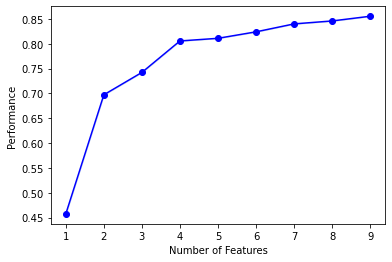

<Figure size 432x288 with 0 Axes>

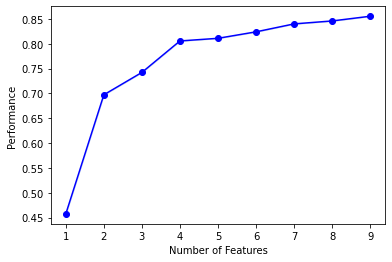

<Figure size 432x288 with 0 Axes>

In [49]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

plot_sfs(sfs.get_metric_dict())
plt.show()
plt.clf()
plot_sfs(sffs.get_metric_dict())
plt.show()
plt.clf()

## Sequential Backward Selection

Sequential forward selection was able to find a feature subset that performed marginally better than the full feature set. Let's use a different sequential method and see how it compares.

Create a sequential backward selection model called `sbs`. 
* Be sure to set the `estimator` parameter to `lr` and set the `forward` and `floating` parameters to the appropriate values.
* Also use the parameters `k_features=7`, `scoring='accuracy'`, and `cv=0`.

In [50]:
sbs=SFS(estimator=lr,k_features=7,forward=False,floating=False,scoring="accuracy",cv=0)
sbfs=SFS(estimator=lr,k_features=7,forward=False,floating=True,scoring="accuracy",cv=0)

### Fit the model

Use the `.fit()` method on `sbs` to fit the model to `X` and `y`.

In [51]:
sbs.fit(x_train,y_train)
sbfs.fit(x_train,y_train)

c:\Users\crane\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\crane\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

SequentialFeatureSelector(cv=0, estimator=LogisticRegression(max_iter=1000),
                          floating=True, forward=False, k_features=7,
                          scoring='accuracy')

### Inspect the results

Now that you've run the sequential backward selection algorithm on the logistic regression model with `X` and `y` you can see what features were chosen and check the model accuracy on the smaller feature set. Print `sbs.subsets_[7]` to inspect the results of sequential backward selection.

In [55]:
print(sbs.subsets_[7])
print(sbfs.subsets_[7])

{'feature_idx': (0, 2, 3, 5, 8, 10, 11), 'cv_scores': array([0.82701422]), 'avg_score': 0.8270142180094787, 'feature_names': ('Gender', 'Height', 'Weight', 'FAVC', 'CAEC', 'CH2O', 'SCC')}
{'feature_idx': (0, 1, 2, 3, 5, 8, 10), 'cv_scores': array([0.84004739]), 'avg_score': 0.840047393364929, 'feature_names': ('Gender', 'Age', 'Height', 'Weight', 'FAVC', 'CAEC', 'CH2O')}


### Chosen features and model accuracy

Use the dictionary `sbs.subsets_[7]` to print a tuple of chosen feature names. Then use it to print the accuracy of the model after doing sequential backward selection. How does this compare to the model's accuracy on all available features?

In [ ]:
print(lr.score(x_train,y_train))
print(sfs.subsets_[9]["avg_score"])
print(sffs.subsets_[9]["avg_score"])
print(sbs.subsets_[7]["avg_score"])
print(sbfs.subsets_[7]["avg_score"])

0.8382701421800948
0.8465639810426541
0.8234597156398105


### Visualize model accuracy

You can visualize the results of sequential backward floating selection just as you did with sequential forward selection. Use the code `plot_sfs(sbs.get_metric_dict())` to plot the model accuracy as a function of the number of features used.

c:\Users\crane\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\crane\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


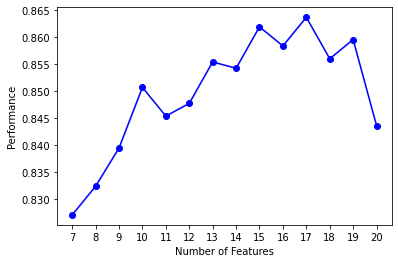

<Figure size 432x288 with 0 Axes>

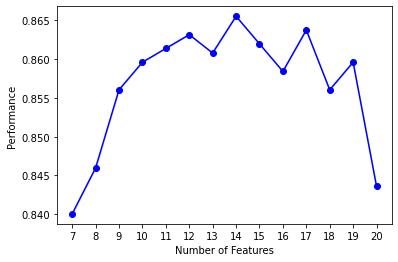

<Figure size 432x288 with 0 Axes>

In [53]:
plot_sfs(sbs.get_metric_dict())
plt.show()
plt.clf()
plot_sfs(sbfs.get_metric_dict())
plt.show()
plt.clf()

Seemingly Best Model So far 

In [ ]:
print(sbs.subsets_[16]["avg_score"])

0.856042654028436


## Recursive Feature Elimination

So far you've tried two different sequential feature selection methods. Let's try one more: recursive feature elimination. First you'll standardize the data, then you'll fit the RFE model and inspect the results.

At a later step of this project, you'll need to be able to access feature names. Enter the code `features = X.columns` for use later.

### Standardize the data

Before doing applying recursive feature elimination it is necessary to standardize the data. Standardize `X` and save it as a DataFrame by creating a `StandardScaler()` object and using the `.fit_transform()` method.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_x=scaler.fit_transform(X)
x_train,x_test,y_train,y_test=train_test_split(scaled_x,y,train_size=0.8)
x_train

array([[ 0.98822657, -0.52212439, -0.2751137 , ..., -0.07237469,
         0.57972058, -0.16507758],
       [-1.01191369,  2.23059597, -0.05632719, ..., -0.07237469,
        -1.72496895, -0.16507758],
       [-1.01191369,  2.07796482, -0.5208827 , ..., -0.07237469,
        -1.72496895, -0.16507758],
       ...,
       [-1.01191369,  0.26457614, -0.89329895, ..., -0.07237469,
         0.57972058, -0.16507758],
       [-1.01191369, -0.67974209, -0.8194589 , ..., -0.07237469,
         0.57972058, -0.16507758],
       [ 0.98822657,  0.37320343,  1.18544624, ..., -0.07237469,
         0.57972058, -0.16507758]])

### Recursive feature elimination model

Create an `RFE()` object that selects `8` features. Be sure to set the `estimator` parameter to `lr`.

In [ ]:
rfe=RFE(estimator=lr,n_features_to_select=8)

### Fit the model

Fit the recursive feature elimination model to `X` and `y`.

In [ ]:
rfe.fit(x_train,y_train)

RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=8)

### Inspect chosen features

Now that you've fit the RFE model you can evaluate the results. Create a list of chosen feature names and call it `rfe_features`. You can use a list comprehension and filter the features in `zip(features, rfe.support_)` based on whether their support is `True` (meaning the model kept them) or `False` (meaning the model eliminated them).

In [ ]:
for (feature, support) in zip(rfe_features, rfe.support_):
    print(feature, support)

Gender True
Age True
Height True
Weight True
family_history_with_overweight True
FAVC False
FCVC True
NCP True
CAEC False
SMOKE False
CH2O False
SCC False
FAF False
TUE False
CALC False
MTRANS False


### Model accuracy

Use the `.score()` method on `rfe` and print the model accuracy after doing recursive feature elimination. How does this compare to the model's accuracy on all available features?

In [ ]:
rfe.score(x_test,y_test)

0.8628841607565012